In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gambit as gb
import subprocess
import itertools

%load_ext autoreload
%autoreload 2

# Simple two-player bargaining game
In this notebook, we're going to solve the standard one-shot model of bargaining with war as an outside option.
## Setting
We're implementing a game similar to what's described on pages 9-10 of [Fearon 1995](https://www.jstor.org/stable/2706903).
Two players indexed by $i \in \{0,1\}$ bargain over a shareable resource of size 1: $x_0+x_1=1$. Players can either agree on a split $(x_0, x_1=1-x_0)$, or fight a war. Players can unilaterally start the war. If war is the outcome, each player pays a cost $c_i>0$, and player 0 has a probability $p$ of winning. The winner takes all the resources for themselves.
## Implementation
Bargaining games usually make the assumption that resources and infinitely divisible, which makes the action space in principle continuous. Gambit can unfortunately only deal with finite action spaces.  To circumvent this problem, we're going to implement the game where a mediator proposes a given split $(x, 1-x)$, which players can either accept or reject. This defines a continuous family $\Gamma(x)$ of discrete games. Varying $x$ allows us to explore the continuum of possible splits.
## Results
The well-known result is that risk-neutral players strictly prefer splits $x \in (p-c_0,p+c_1)$ to war. Let's show this numerically!

# Step-by-step construction of the game

In [2]:
# create a game and add players
g = gb.Game.new_tree()
g.title = "Mediator_bargaining"
P0 = g.players.add("P0")
P1 = g.players.add("P1")
# payoff's data type (Gambit can also perform exact arithmetic on rationals)
gb_type = gb.Decimal

In [3]:
# choose parameters
p = 0.4
costs = [0.1, 0.1]
x = 0.35

In [4]:
# compute the payoffs

# if war is the outcome
war = g.outcomes.add("war")
war[0] = gb_type( p - costs[0] )
war[1] = gb_type( 1 - p - costs[1] )

# if peace is the outcome
peace = g.outcomes.add("peace")
peace[0] = gb_type(x)
peace[1] = gb_type(1 - x)

In [5]:
# set up the game tree

# the game has by default a unique node called "root"
# we give it two children, and specify that they correspond to actions taken by P0
moves = g.root.append_move(P0, 2)
moves.label = 'P0decision'
moves.actions[0].label = 'accept'
moves.actions[1].label = 'fight'

# now let's add P1's actions
for node in g.root.children:
    moves = node.append_move(P1, 2)
    moves.label = 'P1decision'
    moves.actions[0].label = 'accept'
    moves.actions[1].label = 'fight'

In [6]:
# By default, Gambit creates a different information set for each player and action
# Let's say that players move simultaneously:
# then we need to tell Gambit that P0's actions belong to a single infoset:
common_infoset = g.root.children[0].infoset
for node in g.root.children:
    node.infoset = common_infoset

In [7]:
# Finally, we attach payoffs to the terminal nodes of the gametree
for node0, action0 in zip(g.root.children, g.root.infoset.actions):
    for node1, action1 in zip(node0.children, node0.infoset.actions):
        if (action0.label == 'fight') or (action1.label == 'fight'):
            node1.outcome = war
        else:
            node1.outcome = peace

In [8]:
# Ask Gambit to find all mixed subgame perfect equilibria
profiles = gb.nash.lcp_solve(g, use_strategic=True, rational=False)

In [9]:
# There's only one equilibrium:
# for this choice of parameters, the equilibrium is peace
profiles[0]

[[1.0, 0.0], [1.0, 0.0]]

In [10]:
profiles[0].payoff()

[0.35, 0.65]

# Peaceful bargaining interval
Now that we've set up our set of games $\Gamma(x)$, let's solve them for a bunch of $x$ and see when peace is the outcome.

In [11]:
def twoplayer_mediator_game(p, c, x):
    g = gb.Game.new_tree()
    g.title = "Mediator_bargaining"
    P0 = g.players.add("P0")
    P1 = g.players.add("P1")

    gb_type = gb.Decimal

    # add outcomes
    war = g.outcomes.add("war")
    war[0] = gb_type( p - c[0] )
    war[1] = gb_type( 1. - p - c[1] )

    peace = g.outcomes.add("peace")
    peace[0] = gb_type(x)
    peace[1] = gb_type(1.-x)

    moves = g.root.append_move(P0, 2)
    moves.label = 'P0decision'
    moves.actions[0].label = 'accept'
    moves.actions[1].label = 'fight'

    for node in g.root.children:
        moves = node.append_move(P1, 2)
        moves.label = 'P1decision'
        moves.actions[0].label = 'accept'
        moves.actions[1].label = 'fight'

    common_infoset = g.root.children[0].infoset
    for node in g.root.children:
        node.infoset = common_infoset
        
    for node0, action0 in zip(g.root.children, g.root.infoset.actions):
        for node1, action1 in zip(node0.children, node0.infoset.actions):
            if (action0.label == 'fight') or (action1.label == 'fight'):
                node1.outcome = war
            else:
                node1.outcome = peace
    
    return g

In [12]:
def get_payoffs(g):
    profiles = gb.nash.lcp_solve(g, use_strategic=True, rational=False)
    assert len(profiles) == 1, "More than one equilibrium found"
    return profiles[0].payoff()

def twoplayer_mediator(p, c, x):
    return get_payoffs(twoplayer_mediator_game(p, costs, x))

In [13]:
p = 0.2
costs = [0.1, 0.1]
xs = np.linspace(0,1, 200)
payoffs = np.array([twoplayer_mediator(p, costs, x) for x in xs])
V0, V1 = payoffs.T

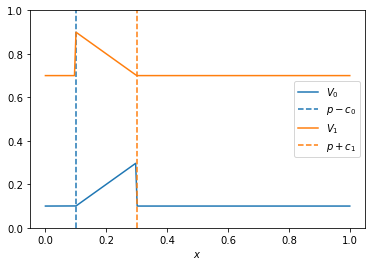

In [19]:
plt.plot(xs, V0, label='$V_0$')
plt.axvline(p-costs[0], color='tab:blue', ls='dashed', label='$p-c_0$')
plt.plot(xs, V1, label='$V_1$')
plt.axvline(p+costs[1], color='tab:orange', ls='dashed', label='$p+c_1$')
plt.xlabel('$x$')
plt.ylim(0, 1)
plt.legend()
plt.show()